Melatih model...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - kl_loss: 5.3029 - loss: 305.7593 - reconstruction_loss: 300.4564 - val_loss: 0.0343
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 5.8463 - loss: 271.0341 - reconstruction_loss: 265.1879 - val_loss: 0.0326
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 5.9640 - loss: 268.0868 - reconstruction_loss: 262.1228 - val_loss: 0.0318
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 6.0198 - loss: 266.3526 - reconstruction_loss: 260.3328 - val_loss: 0.0309
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 6.0591 - loss: 265.3362 - reconstruction_loss: 259.2771 - val_loss: 0.0303

Menampilkan hasil rekonstruksi...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

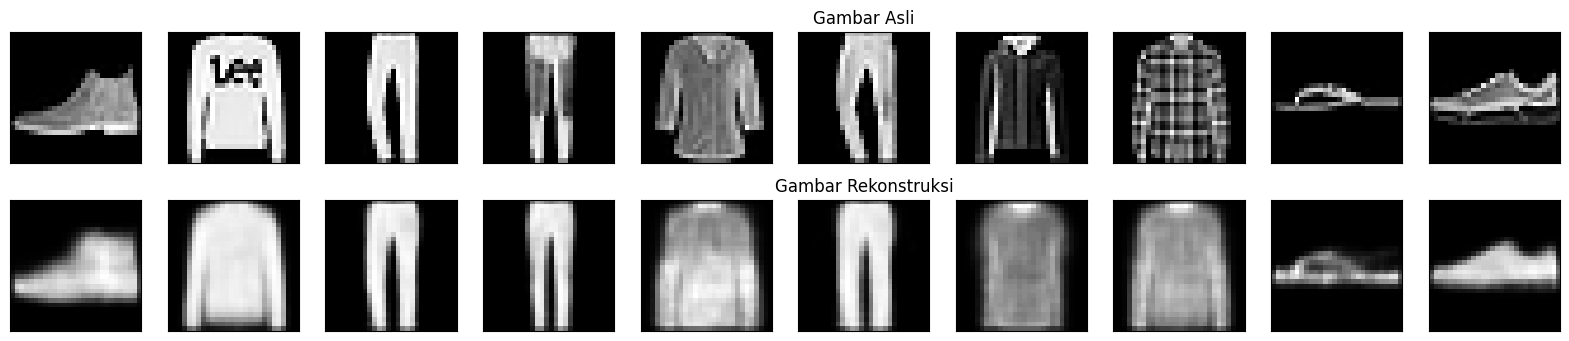


Menampilkan visualisasi ruang laten...
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


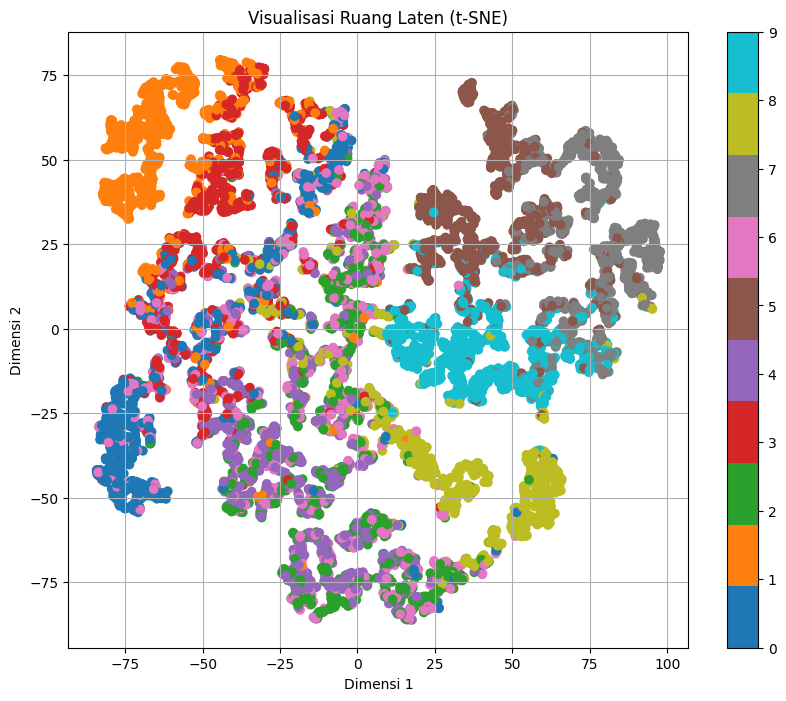


Menghasilkan gambar-gambar baru dari ruang laten...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


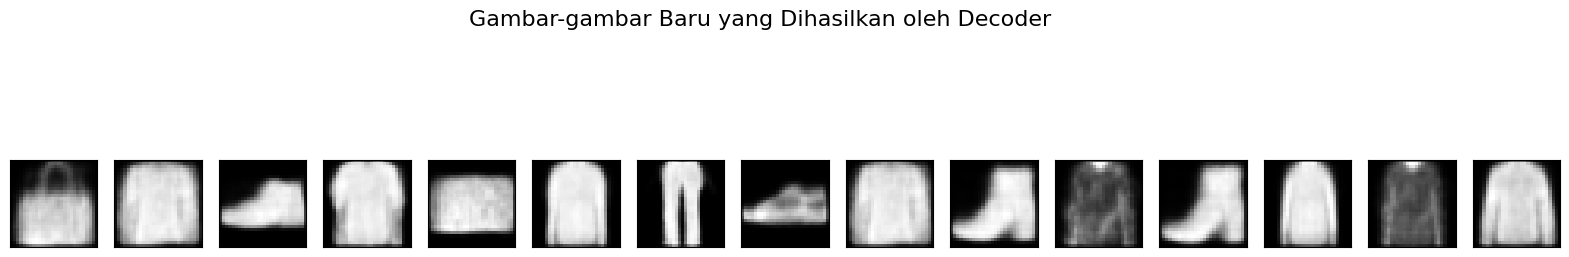

Melakukan interpolasi di ruang laten...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


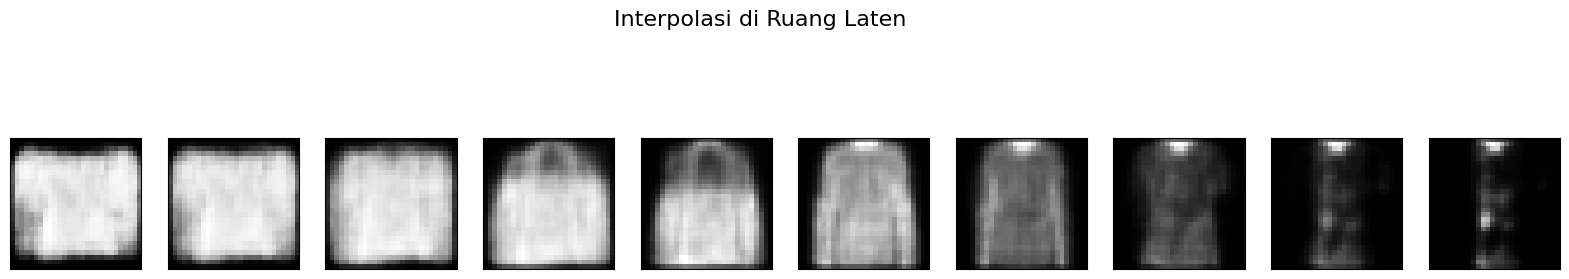

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from sklearn.manifold import TSNE

# ----- Konfigurasi dan Persiapan Data -----

# Parameter model:
# img_rows, img_cols, img_chns: Dimensi gambar input (28x28 piksel, 1 channel untuk grayscale).
# latent_dim: Dimensi ruang laten. Keputusan menggunakan 2 dimensi (2D)
# adalah untuk tujuan visualisasi. Ruang laten 2D memungkinkan kita
# memplot dan melihat bagaimana model mengorganisir data. Untuk model
# yang lebih kompleks, dimensi ini biasanya lebih besar (misalnya, 64 atau 128)
# untuk menangkap lebih banyak variasi.
# batch_size: Jumlah sampel per iterasi pelatihan.
# epochs: Jumlah iterasi penuh pada seluruh dataset.
# learning_rate: Ukuran langkah untuk optimizer Adam.
img_rows, img_cols, img_chns = 28, 28, 1
latent_dim = 2
batch_size = 128
epochs = 5
learning_rate = 1e-3

# Muat dataset Fashion-MNIST. Dataset ini digunakan
# karena relatif kecil dan cocok untuk eksperimen.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalisasi dan reshape data.
# x_train.astype('float32') / 255.: Normalisasi mengubah nilai piksel
# dari rentang [0, 255] menjadi [0, 1]. Ini adalah praktik standar
# karena membantu model belajar lebih stabil dan cepat.
# x_train.reshape(...): Mengubah bentuk data menjadi format yang
# diharapkan oleh lapisan Conv2D: (jumlah_sampel, tinggi, lebar, channel).
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + (img_rows, img_cols, img_chns))
x_test = x_test.reshape((x_test.shape[0],) + (img_rows, img_cols, img_chns))
input_shape = (img_rows, img_cols, img_chns)

# ----- Arsitektur Model -----

def create_encoder():
    """Membangun model encoder. Encoder bertugas memampatkan (compress)
    gambar input menjadi representasi laten di ruang laten.
    """
    encoder_input = Input(shape=input_shape)
    # Lapisan Conv2D dengan strides=(1,1) mempertahankan dimensi spasial.
    x = Conv2D(32, 3, padding='same', activation='relu', strides=(1, 1))(encoder_input)
    # Lapisan Conv2D dengan strides=(2,2) mengurangi dimensi spasial gambar
    # menjadi setengah (28 -> 14).
    x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
    # Lapisan ini mengurangi dimensi lagi (14 -> 7).
    x = Conv2D(128, 3, padding='same', activation='relu', strides=(2, 2))(x)
    # shape_before_flattening: Menyimpan bentuk tensor sebelum di-flatten.
    # Ini sangat penting karena decoder perlu mengetahui bentuk ini untuk
    # bisa mengubah vektor laten kembali menjadi gambar.
    shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)
    # Lapisan Dense (Fully Connected) untuk memetakan vektor fitur
    # ke z_mean (rata-rata) dan z_log_var (log-variansi) dari distribusi laten.
    # z_mean dan z_log_var adalah parameter dari distribusi Gauss yang dipelajari.
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    return Model(encoder_input, [z_mean, z_log_var], name='encoder'), shape_before_flattening

class Sampling(tf.keras.layers.Layer):
    """
    Trik Reparameterisasi:
    Ini adalah inti dari VAE. Kita tidak bisa melakukan backpropagation
    melalui operasi sampling acak (`tf.random.normal`). Jadi, kita
    menggunakan trik ini untuk "memisahkan" keacakan dari jalur
    backpropagation.
    `z = z_mean + exp(0.5 * z_log_var) * epsilon`, di mana epsilon adalah
    variabel acak standar (mean=0, std=1). Backpropagation sekarang
    hanya melalui z_mean dan z_log_var, bukan epsilon.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def create_decoder(shape_before_flattening):
    """Membangun model decoder. Decoder bertugas merekonstruksi gambar
    dari representasi laten.
    """
    decoder_input = Input(shape=(latent_dim,))
    # Lapisan Dense dan Reshape: Mengubah vektor laten menjadi
    # bentuk tensor 3D yang bisa diterima oleh lapisan dekonvolusi.
    x = Dense(np.prod(shape_before_flattening), activation='relu')(decoder_input)
    x = Reshape(shape_before_flattening)(x)
    # Lapisan Conv2DTranspose ("dekonvolusi"): Lapisan ini melakukan
    # upsampling. Dengan strides=(2,2), dimensi spasial akan digandakan.
    # 7x7 -> 14x14
    x = Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
    # 14x14 -> 28x28
    x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
    # Lapisan output: Lapisan ini mengembalikan dimensi gambar ke
    # 28x28. Stride=(1,1) agar tidak mengubah dimensi spasial.
    # Aktivasi 'sigmoid' memastikan output berada dalam rentang [0, 1],
    # sesuai dengan data input yang telah dinormalisasi.
    x = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', strides=(1, 1))(x)
    return Model(decoder_input, x, name='decoder')

class VAE(tf.keras.Model):
    """
    Implementasi VAE menggunakan Model Subclassing. Ini adalah praktik
    terbaik untuk model dengan logika pelatihan yang kompleks, seperti
    menghitung dua jenis loss secara bersamaan.
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampling()

    def call(self, inputs):
        # Metode 'call' ini mendefinisikan alur maju (forward pass)
        # dari model, dari input ke output.
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampler((z_mean, z_log_var))
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        """
        Metode train_step() yang dikustomisasi. Ini adalah inti dari
        pelatihan VAE, di mana kita menghitung dua jenis loss yang berbeda.
        """
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Menggunakan GradientTape untuk merekam semua operasi
            # yang relevan untuk perhitungan gradien.
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler((z_mean, z_log_var))
            reconstruction = self.decoder(z)
            
            # Reconstruction Loss:
            # Mengukur seberapa akurat gambar yang direkonstruksi
            # dibandingkan dengan gambar aslinya.
            # binary_crossentropy cocok untuk data biner atau data
            # gambar yang dinormalisasi ke [0,1].
            # tf.reduce_mean(...) memastikan loss dihitung rata-rata
            # di seluruh batch.
            # Mengalikan dengan img_rows * img_cols memastikan bahwa
            # loss tidak bergantung pada resolusi gambar.
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(K.flatten(data), K.flatten(reconstruction))
            )
            reconstruction_loss *= img_rows * img_cols
            
            # KL (Kullback-Leibler) Loss:
            # Mengukur seberapa jauh distribusi laten (yang diwakili oleh
            # z_mean dan z_log_var) menyimpang dari distribusi normal
            # standar. Tujuan dari loss ini adalah untuk memaksa model
            # untuk mengatur ruang laten dengan cara yang halus dan terstruktur.
            # Tanpa ini, model mungkin hanya akan menghafal data dan
            # tidak dapat menghasilkan gambar baru yang realistis.
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            kl_loss = tf.reduce_mean(kl_loss)
            
            # Loss Total: Gabungan dari kedua loss.
            total_loss = reconstruction_loss + kl_loss
        
        # Hitung gradien untuk loss total terhadap semua bobot model yang bisa dilatih.
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Terapkan gradien menggunakan optimizer yang sudah dikonfigurasi.
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Kembalikan metrik yang akan ditampilkan selama pelatihan.
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Buat dan kompilasi model
encoder, shape_for_decoder = create_encoder()
decoder = create_decoder(shape_for_decoder)
vae = VAE(encoder, decoder)
# Menggunakan dummy loss (MeanSquaredError) pada tahap kompilasi.
# Loss yang sebenarnya sudah dihitung di dalam train_step().
# Ini dilakukan untuk memuaskan persyaratan Keras agar model bisa dikompilasi.
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MeanSquaredError())

# Latih model
print("Melatih model...")
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

# ----- Analisis Hasil -----

# 1. Analisis Rekonstruksi
# Bagian ini memvisualisasikan kemampuan VAE untuk merekonstruksi
# gambar yang sudah ada. Gambar yang direkonstruksi yang tampak
# jelas menunjukkan bahwa encoder dan decoder bekerja dengan baik.
print("\nMenampilkan hasil rekonstruksi...")
n = 10  # Jumlah gambar untuk ditampilkan
plt.figure(figsize=(20, 4))
for i in range(n):
    # Gambar asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title('Gambar Asli')

    # Gambar rekonstruksi
    reconstructed_img = vae.predict(x_test[i].reshape(1, 28, 28, 1))
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title('Gambar Rekonstruksi')
plt.show()

# 2. Analisis Representasi Laten
# Visualisasi ruang laten menggunakan t-SNE. Jika VAE berhasil belajar,
# titik-titik dari kelas yang sama (misalnya, semua sepatu) akan
# berkelompok bersama-sama, menunjukkan bahwa model berhasil
# mengorganisir data dalam ruang laten. 
print("\nMenampilkan visualisasi ruang laten...")
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]

# Reduksi dimensi ke 2D menggunakan t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(x_test_encoded)

# Plot hasilnya
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test, cmap='tab10')
plt.colorbar(scatter, ticks=range(10))
plt.title('Visualisasi Ruang Laten (t-SNE)')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.grid(True)
plt.show()

# ----- Generasi Gambar Baru -----

print("\nMenghasilkan gambar-gambar baru dari ruang laten...")
n = 15
# Gambar baru yang dihasilkan dari titik-titik acak di ruang laten.
# Decoder dapat menghasilkan gambar-gambar baru dari vektor laten acak
# karena loss KL telah memaksa ruang laten menjadi distribusi yang terstruktur
# dan mudah disampling.
random_latent_vectors = np.random.normal(size=(n, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle('Gambar-gambar Baru yang Dihasilkan oleh Decoder', fontsize=16)
plt.show()

# Interpolasi di ruang laten
# Interpolasi menunjukkan bahwa ruang laten yang dipelajari
# bersifat "kontinu" atau "halus". Berjalan dari satu titik ke
# titik lain dalam ruang laten akan menghasilkan transisi
# yang mulus antara gambar-gambar yang berbeda,
# membuktikan bahwa model tidak memiliki "lubang" dalam pemahamannya.
print("Melakukan interpolasi di ruang laten...")
num_interpolations = 10
start_point = np.array([-2, -2]) # Contoh titik awal
end_point = np.array([2, 2])     # Contoh titik akhir
interpolation_steps = np.linspace(start_point, end_point, num_interpolations)

interpolated_images = decoder.predict(interpolation_steps)

plt.figure(figsize=(20, 4))
for i in range(num_interpolations):
    ax = plt.subplot(1, num_interpolations, i + 1)
    plt.imshow(interpolated_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle('Interpolasi di Ruang Laten', fontsize=16)
plt.show()